In [1]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')

C:\Users\Almalis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [4]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")
print("Number of Examples : ",len(X))
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")
X.to_csv (r'Tech.csv', index = False, header=True)

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n")

y=target_arrange(X['Target'])

print("Negative Examples : ",(y==0.0).sum())
print("Positive Examples : ",(y==1.0).sum())
print("Neutral Examples : ", (y==2.0).sum())





Number of Examples :  16801
Number of Examples after removing duplicates:  16544 

Number of words before cleaning :  623596
Number of words after cleaning :  419253


Negative Examples :  2066
Positive Examples :  6252
Neutral Examples :  8226


In [5]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])

print(X['Article'])

0        progress second quarter revenu exce guidanc in...
1        acuiti brand declar quarterli dividend atlanta...
2        mercuri system receiv contract award base new ...
3         share factset soar today earn came better expect
4        stifel say inseego leader inseego corp nasdaq ...
                               ...                        
16539    stock week sell short micron nrg energi like c...
16540    hubspot surg august digit market softwar compa...
16541    dividend increas expect septemb august anoth e...
16542    jcom final deadlin rosen trust top rank law fi...
16543    appfolio stock jump august softwar compani reb...
Name: Article, Length: 16544, dtype: object


In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9)
Xv = tfidf_vectorizer.fit_transform(X['Article'])
Xv = pd.DataFrame(Xv.todense())
X_train,X_test,y_train,y_test = train_test_split(Xv,y, test_size=0.25,stratify=y)


ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print("\n After OverSampling \n")

print("Negative Examples : ",(y_ros==0.0).sum())
print("Positive Examples : ",(y_ros==1.0).sum())
print("Neutral Examples : ", (y_ros==2.0).sum())



 After OverSampling 

Negative Examples :  6170
Positive Examples :  6170
Neutral Examples :  6170


## Naive Bayes without OverSampling


Metrics

 Recall metric: 0.7139242821394861
 F1 metric: 0.7183865303146764
 Precision metric: 0.7329269552752482
 Accuracy metric: 0.7623307543520309
 Balanced Accuracy metric: 0.7139242821394861 

**************************************************

Normalized confusion matrix
[[0.54 0.34 0.12]
 [0.04 0.85 0.12]
 [0.05 0.2  0.75]]


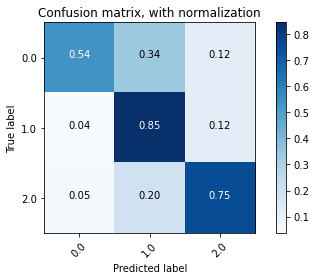

In [7]:
alpha = 0.1 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(X_train,y_train)
y_predicted = model.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')


## Naive Bayes with OverSampling


Metrics after OverSampling

 Recall metric: 0.7525042793742901
 F1 metric: 0.7214153364541748
 Precision metric: 0.7105257989371122
 Accuracy metric: 0.7545938104448743
 Balanced Accuracy metric: 0.7525042793742901 

**************************************************

Normalized confusion matrix
[[0.73 0.21 0.05]
 [0.11 0.8  0.09]
 [0.09 0.18 0.72]]


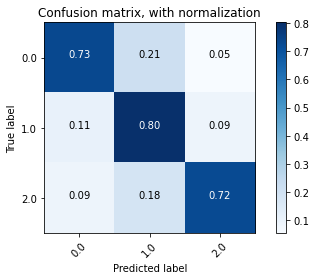

In [8]:
alpha = 0.1 # This is the smoothing parameter for Laplace/Lidstone smoothing
model2 = naive_bayes.MultinomialNB(alpha=alpha)

model2.fit(X_ros,y_ros)
y_predicted = model2.predict(X_test)

print("\nMetrics after OverSampling\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')

In [ ]:
""""
skfold = model_selection.StratifiedKFold(n_splits=5,random_state=1)

model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
results = model_selection.cross_val_score(model2, Xv,y, cv=skfold,scoring='balanced_accuracy',n_jobs=-1)
print("Balanced Accuracy : ",results.mean())

model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
results = model_selection.cross_val_score(model2, Xv,y, cv=skfold,scoring='accuracy',n_jobs=-1)
print("Accuracy : ",results.mean())"""


## Random Forest without OverSampling


Metrics without OverSampling

 Recall metric: 0.7587401578893571
 F1 metric: 0.7792708878860353
 Precision metric: 0.8256103355373989
 Accuracy metric: 0.816247582205029
 Balanced Accuracy metric: 0.7587401578893571 

**************************************************

Normalized confusion matrix
[[0.56 0.33 0.11]
 [0.01 0.89 0.1 ]
 [0.02 0.16 0.82]]


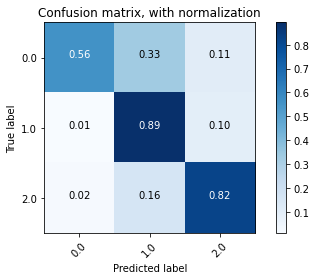

In [9]:
model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
model2.fit(X_train,y_train)
y_predicted = model2.predict(X_test)

print("\nMetrics without OverSampling\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')

## Random Forest with OverSampling


Metrics with OverSampling

 Recall metric: 0.7950804425371688
 F1 metric: 0.8001927721770903
 Precision metric: 0.8157587903362254
 Accuracy metric: 0.8259187620889749
 Balanced Accuracy metric: 0.7950804425371688 

**************************************************

Normalized confusion matrix
[[0.68 0.25 0.07]
 [0.02 0.91 0.07]
 [0.03 0.17 0.8 ]]


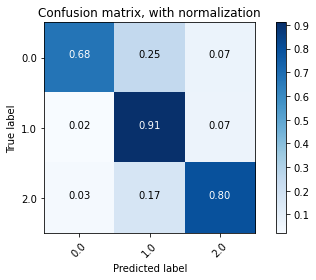

In [14]:
model3 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
model3.fit(X_ros,y_ros)
y_predicted = model3.predict(X_test)

print("\nMetrics with OverSampling\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')